In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the dashboard
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Overview

In this notebook I have created a dashboard giving an overview of the problems in Zürich. The map shows the location of all problems, what the problem is and the status of the problem. The user can filter by the type of problem, to see only the problems of interest, e.g. only the problems with the type "Graffiti" that are still open.

### Why?/Usecases

Citizens can use this dashboard to see what problems there are in Zurich, to stay up to date.

If a citizen is planning a late picnic in Irchel Park, they can check the dashboard to see if there are any problems in the park, e.g.:

if the lighting is broken, they might have to bright a lamp themselves.
there was one (albeit erroneous) report of a type of mosquito that can carry the dangerous Dengue fever, so they might want to choose a different park.


Benevolent citizens can filter by cases of graffiti that are not fixed yet and clean it up themselves.

If you are moving to Wiedikon and don't know much about the area, you can check the dashboard to see what problems there are in the area, and if they are being fixed.


For the people behind "Zurich wie neu", this dashboard could maybe offer a different overview of the city's problems.


### Data

This data set is from "Zurich wie neu" (Zurich like new), a program where citizens can report problems or flaws in the city. Stadt Zurich will then respond to the report and ideally fix the problem.

The (important) columns in the data set are:

coordinates (e,n): the coordinates of the problem in Swiss (east, north) format

service_code: the type of problem in 10 categories

status: the status of the problem

requested_datetime: the date and time the problem was reported

updated_datetime: the date and time the problem was updated. If updated to "fixed" it indicates the time it took to fix the problem.

detail: a description of the problem from the citizen

media_url: a link to a picture of the problem uploaded by the citizen


### Analysis

The goal is to find some interesting insights in the data set and put it into a dashboard. The dashboard will be created using Plotly Dash.

### Dashboard Goals

The dashboard should:

Have a map of Zurich with the problems marked on it. The user should be able to select a problem and see the type, status, and when it was reported and updated.

Have a dropdown menu to filter by the type of problem.



## Inspect data

In [2]:
data_raw = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/ZWN_data/data/stzh_zwn_meldungen_p.csv')

data_raw.head()

,objectid,service_request_id,e,n,service_code,status,detail,media_url,interface_used,requested_datetime,agency_sent_datetime,updated_datetime,service_notice,title,description,service_name,url,geometry
0,1,1,2678968.0,1247548.0,Strasse/Trottoir/Platz,fixed - council,Auf dem Asphalt des Bürgersteigs hat es eine E...,NaN,Web interface,20130314151615,2.013040e+13,20130412075930,Diese Reparatur wird von uns in den kommenden ...,Auf dem Asp,Auf dem Asp: Auf dem Asphalt des Bürgersteigs ...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/1,POINT (2678968 1247548)
1,2,2,2680746.0,1249916.0,Strasse/Trottoir/Platz,fixed - council,Vermessungspunkt ist nicht mehr bündig mit dem...,NaN,Web interface,20130314151757,2.013033e+13,20130412080022,Diese Reparatur wird von uns in den kommenden ...,Vermessungs,Vermessungs: Vermessungspunkt ist nicht mehr b...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/2,POINT (2680746 1249916)
2,3,4,2684605.0,1251431.0,Strasse/Trottoir/Platz,fixed - council,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Web interface,20130315091416,2.013032e+13,20130412080810,Diese Reparatur wird von uns in den kommenden ...,Beim Trotto,Beim Trotto: Beim Trottoir sind einige Randste...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/4,POINT (2684605 1251431)
3,4,5,2681754.0,1250376.0,Strasse/Trottoir/Platz,fixed - council,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Web interface,20130315091715,2.013032e+13,20130412080905,Diese Reparatur wird von uns in den kommenden ...,Auf dem Par,Auf dem Par: Auf dem Parkplatz beim Waidspital...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/5,POINT (2681754 1250376)
4,5,6,2683094.0,1247762.0,Abfall/Sammelstelle,fixed - council,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Web interface,20130315103653,2.013042e+13,20130423135033,Dieses Graffiti wird von uns in den kommenden ...,Arbeitskist,Arbeitskist: Arbeitskiste ist rund herum versc...,Abfall/Sammelstelle,https://www.zueriwieneu.ch/report/6,POINT (2683094 1247762)


## Data preprocessing

In [3]:
# Remove duplicate column
(data_raw['service_name'] == data_raw['service_code']).all()
data = data_raw.drop('service_code', axis=1)

In [4]:
# Convert timestamp to datetime format
date_columns = ['requested_datetime', 'agency_sent_datetime', 'updated_datetime']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], format='%Y%m%d%H%M%S')

data[date_columns]

,requested_datetime,agency_sent_datetime,updated_datetime
0,2013-03-14 15:16:15,2013-04-04 07:25:05,2013-04-12 07:59:30
1,2013-03-14 15:17:57,2013-03-26 14:05:05,2013-04-12 08:00:22
2,2013-03-15 09:14:16,2013-03-15 09:55:05,2013-04-12 08:08:10
3,2013-03-15 09:17:15,2013-03-20 10:05:05,2013-04-12 08:09:05
4,2013-03-15 10:36:53,2013-04-22 18:25:05,2013-04-23 13:50:33
...,...,...,...
54140,2024-09-04 16:29:01,2024-09-04 16:32:05,2024-09-04 19:00:15
54141,2024-09-04 16:43:28,2024-09-04 16:47:04,2024-09-04 19:14:00
54142,2024-09-04 16:46:14,2024-09-04 17:22:04,2024-09-04 17:22:04
54143,2024-09-04 16:51:49,2024-09-04 16:52:05,2024-09-04 16:53:07


In [5]:
data['media_url'].fillna('No media', inplace=True)

In [6]:
# Add time it took to fix the problem
data[data['status'] == 'fixed - council'][['requested_datetime', 'updated_datetime']]
data['service_time'] = np.zeros(data.shape[0])
data['service_time'] = data['updated_datetime'] - data['requested_datetime']
data['service_time'] = data['service_time'].dt.total_seconds() / 60 / 60

# Add report_day as a column
data['report_day'] = data['requested_datetime'].dt.day_name()
# Add report_year
data['report_year'] = data['requested_datetime'].dt.year

# Ensure years and weekdays are ordered for plotting later
years = sorted(data['requested_datetime'].dt.year.unique())
weekdays = sorted(data['requested_datetime'].dt.day_name().unique(), key=lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x))


Converting the coordinates from the swiss east and north format to latitude and longitude.

In [7]:
from pyproj import Transformer

# Define the transformer for converting CH1903+ / LV95 to WGS84
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)


# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])

# Apply the function to each row in the DataFrame
data[['longitude', 'latitude']] = data.apply(transform_coordinates, axis=1)


In [8]:
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import Point
from pyproj import Transformer

# Define the transformer for converting CH1903+ / LV95 to WGS84
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])

# Apply the function to each row in the DataFrame
data[['longitude', 'latitude']] = data.apply(transform_coordinates, axis=1)


In [9]:
# Add media support: Show the picture if possible.
df = data[['longitude', 'latitude', 'status', 'requested_datetime', 'updated_datetime', 'service_time', 'service_name', 'report_day', 'report_year', 'detail', 'media_url', 'service_notice']]
df

,longitude,latitude,status,requested_datetime,updated_datetime,service_time,service_name,report_day,report_year,detail,media_url,service_notice
0,8.484226,47.374038,fixed - council,2013-03-14 15:16:15,2013-04-12 07:59:30,688.720833,Strasse/Trottoir/Platz,Thursday,2013,Auf dem Asphalt des Bürgersteigs hat es eine E...,No media,Diese Reparatur wird von uns in den kommenden ...
1,8.508193,47.395119,fixed - council,2013-03-14 15:17:57,2013-04-12 08:00:22,688.706944,Strasse/Trottoir/Platz,Thursday,2013,Vermessungspunkt ist nicht mehr bündig mit dem...,No media,Diese Reparatur wird von uns in den kommenden ...
2,8.559589,47.408259,fixed - council,2013-03-15 09:14:16,2013-04-12 08:08:10,670.898333,Strasse/Trottoir/Platz,Friday,2013,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Diese Reparatur wird von uns in den kommenden ...
3,8.521627,47.399131,fixed - council,2013-03-15 09:17:15,2013-04-12 08:09:05,670.863889,Strasse/Trottoir/Platz,Friday,2013,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Diese Reparatur wird von uns in den kommenden ...
4,8.538891,47.375455,fixed - council,2013-03-15 10:36:53,2013-04-23 13:50:33,939.227778,Abfall/Sammelstelle,Friday,2013,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Dieses Graffiti wird von uns in den kommenden ...
...,...,...,...,...,...,...,...,...,...,...,...,...
54140,8.520284,47.403434,fixed - council,2024-09-04 16:29:01,2024-09-04 19:00:15,2.520556,Schädlinge,Wednesday,2024,Bei Waldspaziergang durch Tigermückenschwarm v...,https://www.zueriwieneu.ch/photo/60666.0.jpeg?...,Vielen Dank für Ihre Meldung. <br/> <br/> Weg...
54141,8.515094,47.379997,fixed - council,2024-09-04 16:43:28,2024-09-04 19:14:00,2.508889,Schädlinge,Wednesday,2024,Sehr geehrte Damen und Herren <br/> <br/> Sie...,https://www.zueriwieneu.ch/photo/60668.0.jpeg?...,Guten Abend <br/> <br/> Das glauben wir Ihnen...
54142,8.507043,47.352313,confirmed,2024-09-04 16:46:14,2024-09-04 17:22:04,0.597222,Grünflächen/Spielplätze,Wednesday,2024,"Flacher Wassertrog, ursprünglich zur Schuhrein...",No media,NaN
54143,8.524451,47.372560,fixed - council,2024-09-04 16:51:49,2024-09-04 16:53:07,0.021667,Abfall/Sammelstelle,Wednesday,2024,Diese KACK Velo versperrt seit Wochen den Velo...,https://www.zueriwieneu.ch/photo/60670.0.jpeg?...,Die Zweiradordnung wird Ihr Anliegen prüfen un...


# Adding Kreise to the data

In [10]:
from shapely import wkt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [11]:
kreis_df = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/kreis_data/data/stzh_adm_stadtkreise_a.csv')
kreis_df.rename(columns={"bezeichnung": "kreis_name"}, inplace=True)

kreis_df.sort_values('name', inplace=True)
kreis_df.drop(['objid','entstehung'], axis=1, inplace=True)
kreis_df.reset_index(drop=True, inplace=True)
kreis_df['geometry'] = kreis_df['geometry'].apply(wkt.loads)


transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])


def transform_polygon(polygon):
    # Transform all coordinates in the polygon
    coords = list(polygon.exterior.coords)
    transformed_coords = [transformer.transform(x, y) for x, y in coords]
    return Polygon(transformed_coords)

#Translate coordinates to lat,lon
kreis_df['geometry'] = kreis_df['geometry'].apply(transform_polygon)  



# Convert df's lat/lon to Shapely Point objects
df['point'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Function to classify each point based on polygons in kreis_df
def classify_point(point, polygons):
    for idx, polygon in enumerate(polygons):
        if polygon.contains(point):
            return idx
    return None


C:\Users\simon\AppData\Local\Temp\ipykernel_13052\4007770953.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['point'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [12]:
# Function to classify points based on polygons
def classify_point(row):
    for _, polygon_row in kreis_df.iterrows():
        if row['point'].within(polygon_row['geometry']):
            return polygon_row['name']
    return 'Unknown'

# Classify each point in the data
df['kreis_name'] = df.apply(classify_point, axis=1)

# Now 'data' DataFrame includes 'kreis_name' which indicates which kreis each point falls into.


C:\Users\simon\AppData\Local\Temp\ipykernel_13052\407688397.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kreis_name'] = df.apply(classify_point, axis=1)


In [13]:
df = df[df['kreis_name'] != 'Unknown']

## Add extra kreis data

In [14]:
kdf_raw = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/kreis_data/kreis_population_data.csv', skiprows=1)
kdf_raw.columns = kdf_raw.iloc[0]
kdf_raw.drop(0, inplace=True)
kdf_raw.reset_index(drop=True, inplace=True)
kdf_raw[['kreis_name', 'Wohnbevolkerung', 'Beschaftige', 'Arbeitsstatten', 'Verpflegungsbetriebe']] = kdf_raw[['kreis_name', 'Wohnbevolkerung', 'Beschaftige', 'Arbeitsstatten', 'Verpflegungsbetriebe']].astype(int)
kdf_raw['Auslanderanteil'] = kdf_raw['Auslanderanteil'].astype(float)
kdf = kdf_raw.copy().iloc[1:]
df.loc[:,'kreis_name'] = df.loc[:,'kreis_name'].astype(int)

In [23]:
plt.rcParams['figure.figsize'] = (17, 10)


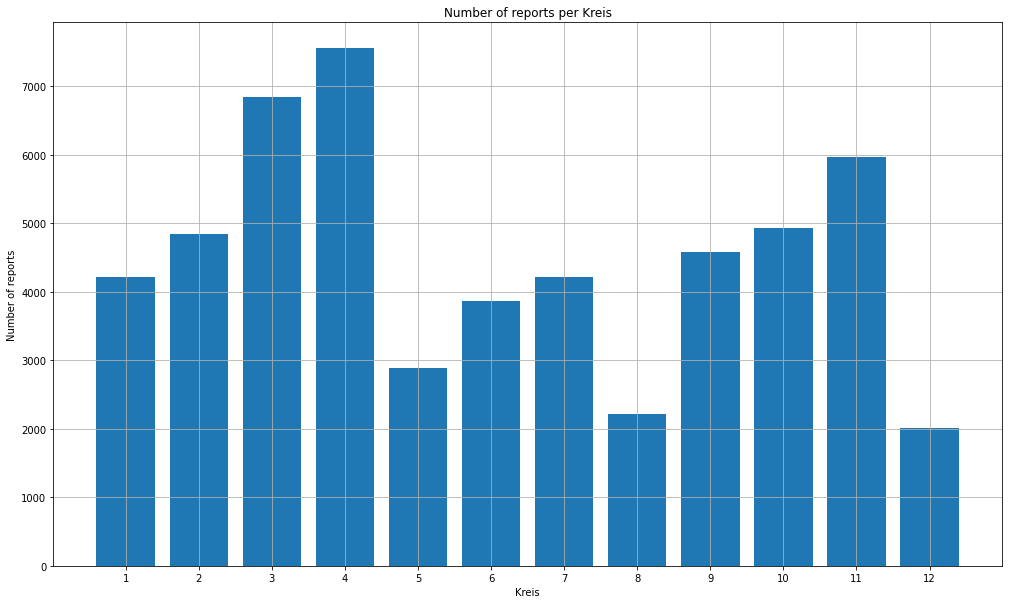

In [24]:
plt.bar(kdf.index, merged_df.groupby('kreis_name')['service_name'].size())
plt.xlabel('Kreis')
plt.ylabel('Number of reports')
plt.title('Number of reports per Kreis')
plt.xticks(kdf.index, kdf['kreis_name'])
plt.grid();

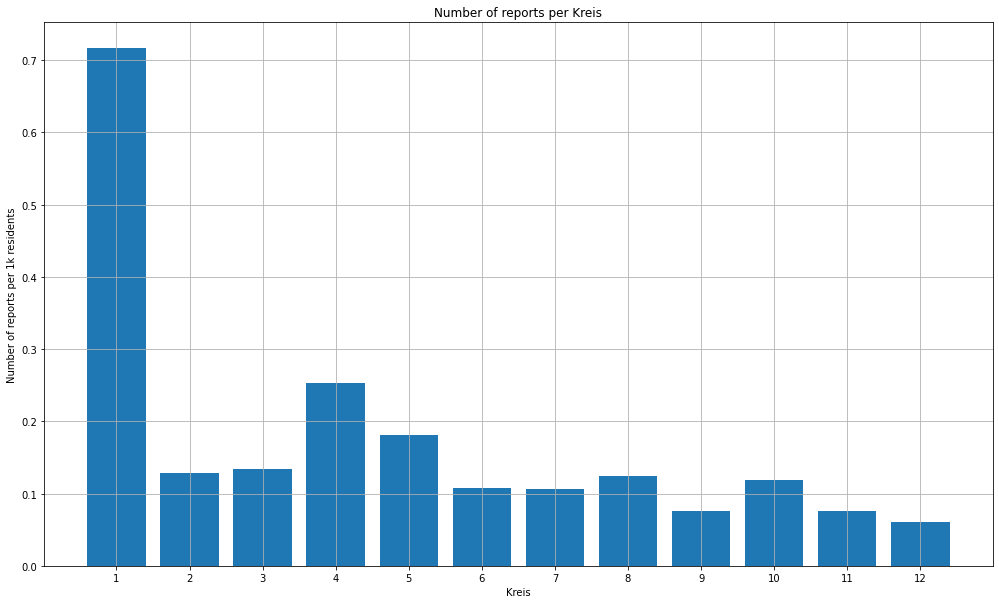

In [25]:
plt.bar(kdf.index, merged_df.groupby('kreis_name')['service_name'].size()/kdf['Wohnbevolkerung'])
plt.xlabel('Kreis')
plt.ylabel('Number of reports per 1k residents')
plt.title('Number of reports per Kreis')
plt.xticks(kdf.index, kdf['kreis_name'])
plt.grid();

In [208]:
kdf['Wohnbevolkerung']

1      5890
2     37639
3     50950
4     29944
5     15874
6     35688
7     39647
8     17860
9     59841
10    41411
11    78801
12    33537
Name: Wohnbevolkerung, dtype: int32

-0.0868587546384014


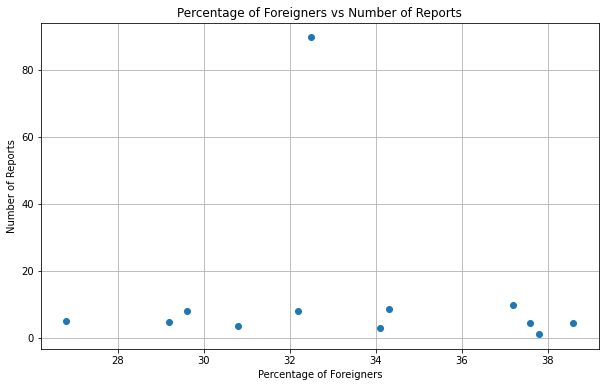

In [20]:
import matplotlib.pyplot as plt

# Merge df and kdf on 'kreis_name'
merged_df = df[df['kreis_name'] != 'Unknown'].merge(kdf.iloc[1:], on='kreis_name', how='left')

# Calculate number of reports per kreis
reports_per_kreis = merged_df[merged_df['service_name'] == 'Graffiti'].groupby('kreis_name').size()
reports_per_1k_inhabitants = reports_per_kreis/kdf['Wohnbevolkerung']*1000
print(reports_per_1k_inhabitants.corr(kdf['Auslanderanteil']))

# Scatter plot of Auslanderanteil (percentage_foreigners) vs number of reports
plt.figure(figsize=(10, 6))
plt.scatter(kdf['Auslanderanteil'], reports_per_1k_inhabitants)
plt.title("Percentage of Foreigners vs Number of Reports")
plt.xlabel("Percentage of Foreigners")
plt.ylabel("Number of Reports")
plt.grid(True)
plt.show()

In [175]:
kdf

,kreis_name,Auslanderanteil,Wohnbevolkerung,Beschaftige,Arbeitsstatten,Verpflegungsbetriebe
0,0,33.6,447082,536980,46671,2258
1,1,32.5,5890,76043,5591,467
2,2,34.3,37639,50704,4314,137
3,3,30.8,50950,47069,4627,231
4,4,37.2,29944,49627,4867,387
5,5,32.2,15874,61148,3278,234
6,6,29.6,35688,29147,3333,105
7,7,29.2,39647,34261,4002,86
8,8,37.6,17860,33041,4211,112
9,9,34.1,59841,69491,4265,148


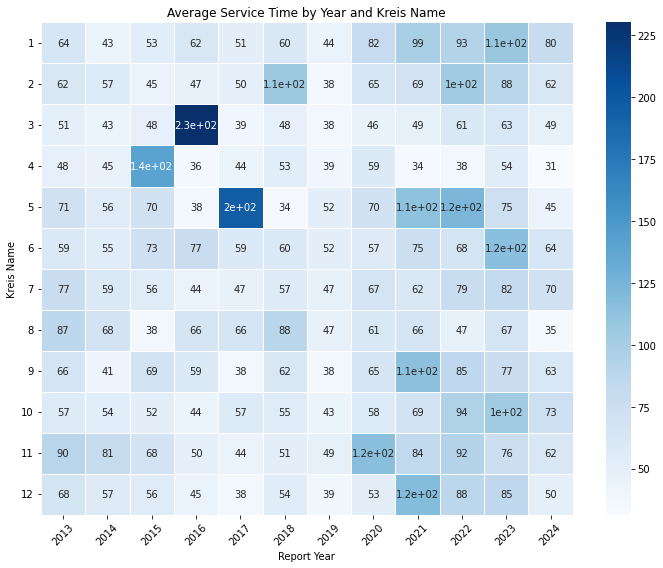

In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# First, group by 'report_year' and 'kreis_name', and calculate the average 'service_time'
average_service_time = df.groupby(['report_year', 'kreis_name'])['service_time'].mean().reset_index()

# Pivot the DataFrame to create the matrix where rows are 'kreis_name' and columns are 'report_year'
service_time_matrix = average_service_time.pivot(index='kreis_name', columns='report_year', values='service_time')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(service_time_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Average Service Time by Year and Kreis Name')
plt.xlabel('Report Year')
plt.ylabel('Kreis Name')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_7040\23906155.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_solved'] = df['status'] == 'fixed - council'


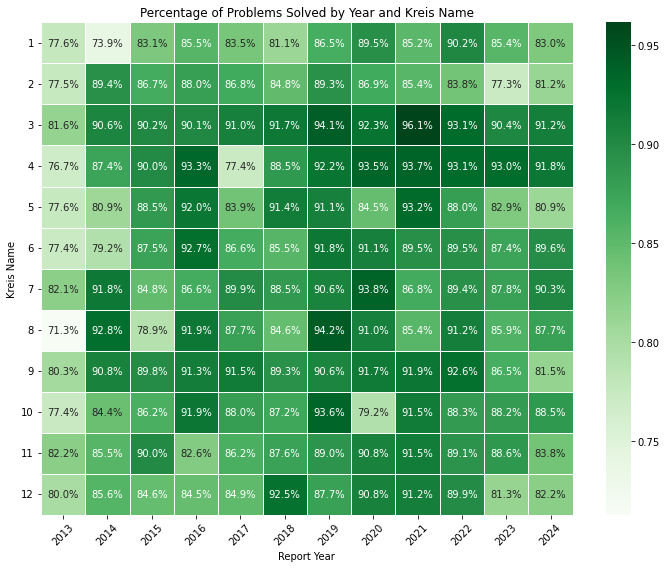

In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Filter only relevant rows where 'status' is either 'fixed - council' or something else
df['is_solved'] = df['status'] == 'fixed - council'

# Group by 'report_year' and 'kreis_name', then calculate the percentage of solved problems
solved_percentage = df.groupby(['report_year', 'kreis_name'])['is_solved'].mean().reset_index()

# Pivot the DataFrame to create the matrix where rows are 'kreis_name' and columns are 'report_year'
solved_matrix = solved_percentage.pivot(index='kreis_name', columns='report_year', values='is_solved')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(solved_matrix, annot=True, cmap='Greens', fmt='.1%', linewidths=0.5)
plt.title('Percentage of Problems Solved by Year and Kreis Name')
plt.xlabel('Report Year')
plt.ylabel('Kreis Name')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_7040\2148201653.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_solved'] = df['status'] == 'fixed - council'


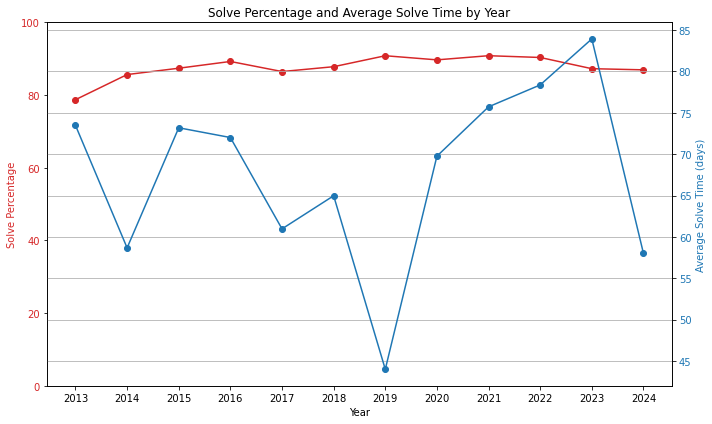

In [239]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Create a new column 'is_solved' for solved problems (status == 'fixed - council')
df['is_solved'] = df['status'] == 'fixed - council'

# Group by 'report_year' and calculate the percentage solved and average solve time
yearly_stats = df.groupby('report_year').agg(
    solve_percentage=('is_solved', 'mean'),
    average_solve_time=('service_time', lambda x: x[df['is_solved']].mean())
).reset_index()

# Plot the solve percentage and average solve time on two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the solve percentage
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Solve Percentage', color=color)
ax1.plot(yearly_stats['report_year'], yearly_stats['solve_percentage'] * 100, color=color, marker='o', label='Solve Percentage')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)  # Set limits for the percentage scale

# Create a second y-axis for average solve time
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Solve Time (days)', color=color)
ax2.plot(yearly_stats['report_year'], yearly_stats['average_solve_time'], color=color, marker='o', label='Average Solve Time')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and grid
plt.title('Solve Percentage and Average Solve Time by Year')
plt.xticks(np.sort(yearly_stats['report_year'].unique()))
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


In [64]:
df['kreis_name']

0         9
1        10
2        12
3        10
4         1
         ..
54140    10
54141     4
54142     3
54143     4
54144     7
Name: kreis_name, Length: 54145, dtype: object

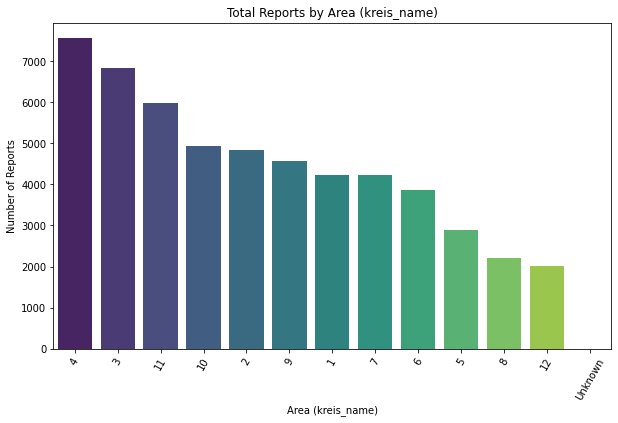

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Report frequency by area (kreis_name)
report_freq_by_area = df['kreis_name'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=report_freq_by_area.index, y=report_freq_by_area.values, palette='viridis')
plt.xticks(rotation=60)
plt.title('Total Reports by Area (kreis_name)')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Number of Reports')
plt.show()


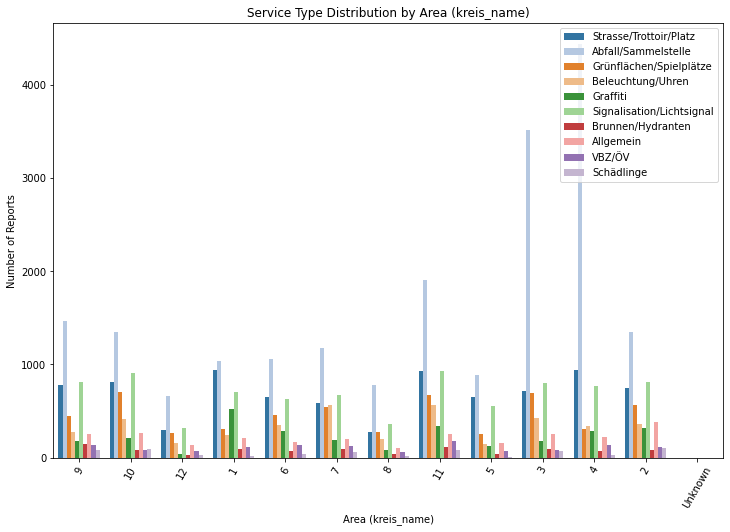

In [14]:
# Service type distribution by area
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='kreis_name', hue='service_name', palette='tab20')
plt.xticks(rotation=60)
plt.title('Service Type Distribution by Area (kreis_name)')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Number of Reports')
plt.legend(loc='upper right')
plt.show()


In [27]:
avg_service_time_by_area.index

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'Unknown'], dtype='object', name='kreis_name')

In [31]:
kreis_x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

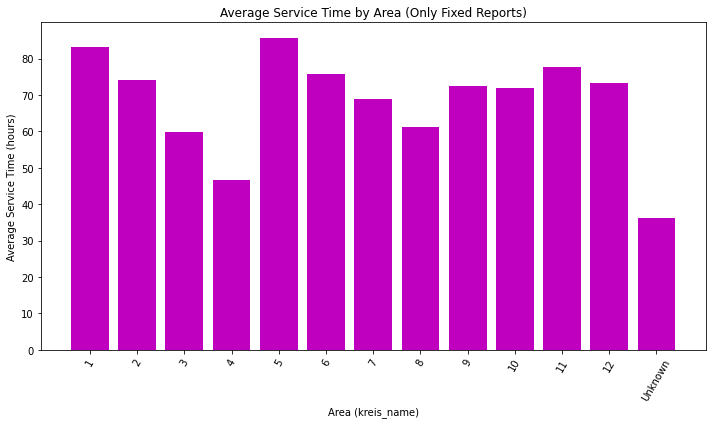

In [32]:
# Average service time by area (only for fixed reports)
fixed_reports = df[df['status'] == 'fixed - council']
avg_service_time_by_area = fixed_reports.groupby('kreis_name')['service_time'].mean()
kreis_x = avg_service_time_by_area.index[:-1].tolist() + [13]
kreis_x_labels = kreis_x[:-1] + ['Unknown']
plt.figure(figsize=(10, 6))
plt.bar(kreis_x, avg_service_time_by_area.values, color='m')
plt.xticks(rotation=60, ticks=kreis_x, labels=kreis_x_labels)
plt.title('Average Service Time by Area (Only Fixed Reports)')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Average Service Time (hours)')
plt.tight_layout()
plt.show()


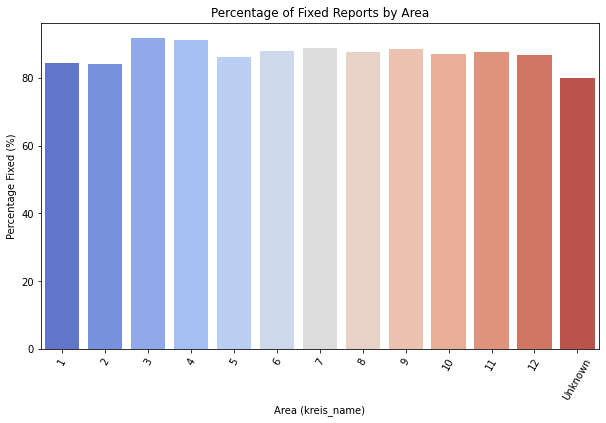

In [33]:
# Percentage of fixed reports by area
total_reports_by_area = df.groupby('kreis_name')['status'].count()
fixed_reports_by_area = df[df['status'] == 'fixed - council'].groupby('kreis_name')['status'].count()
percentage_fixed_by_area = (fixed_reports_by_area / total_reports_by_area) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=percentage_fixed_by_area.index, y=percentage_fixed_by_area.values, palette='coolwarm')
plt.xticks(rotation=60)
plt.title('Percentage of Fixed Reports by Area')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Percentage Fixed (%)')
plt.show()


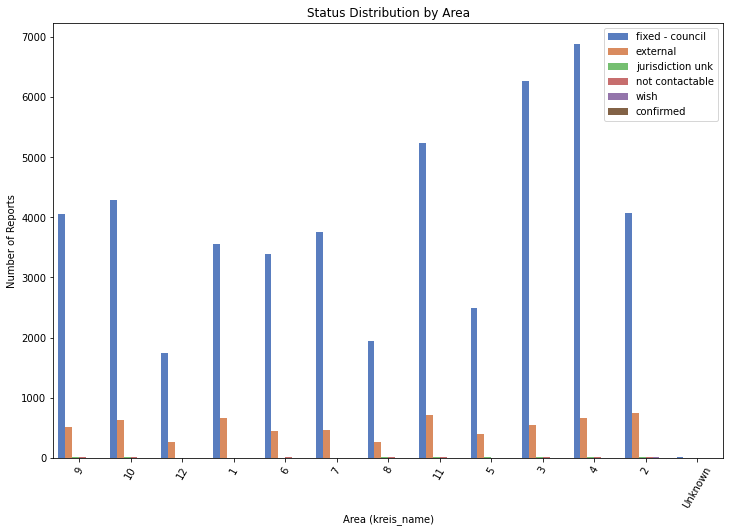

In [18]:
# Status comparison by area
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='kreis_name', hue='status', palette='muted')
plt.xticks(rotation=60)
plt.title('Status Distribution by Area')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Number of Reports')
plt.legend(loc='upper right')
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_7040\3190044075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['report_month'] = df['requested_datetime'].dt.to_period('M')


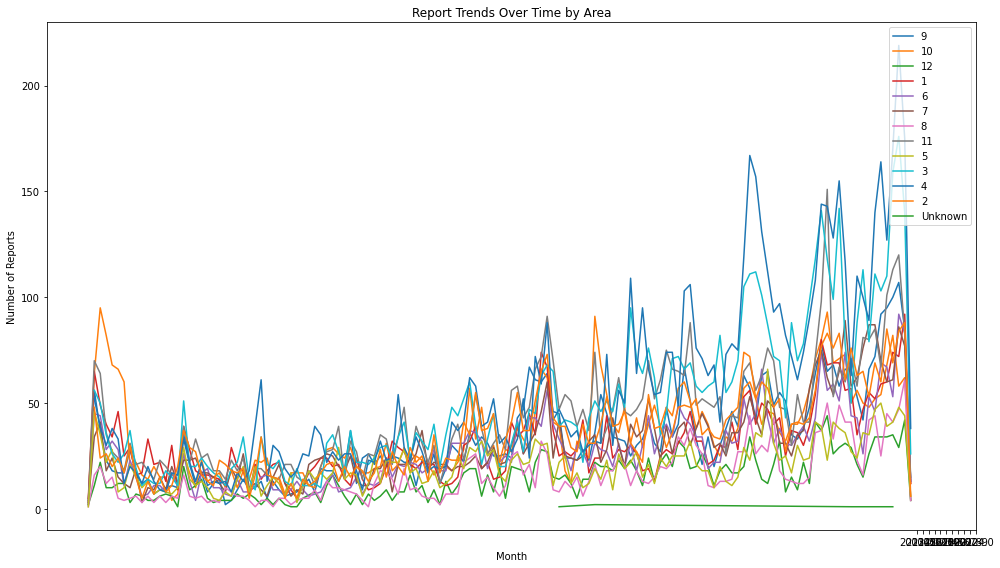

In [36]:
# Convert datetime to a monthly period
df['report_month'] = df['requested_datetime'].dt.to_period('M')

# Trend of reports over time by area
plt.figure(figsize=(14, 8))
for kreis in df['kreis_name'].unique():
    kreis_data = df[df['kreis_name'] == kreis]['report_month'].value_counts().sort_index()
    plt.plot(kreis_data.index.astype(str), kreis_data.values, label=kreis)

plt.xticks([str(x) for x in np.linspace(2013, 2024, 11)])
plt.title('Report Trends Over Time by Area')
plt.xlabel('Month')
plt.ylabel('Number of Reports')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [39]:
avg_service_time_by_area.head()

kreis_name
1    83.162249
2    74.151308
3    59.780826
4    46.659662
5    85.645194
Name: service_time, dtype: float64

0.12278448633090949


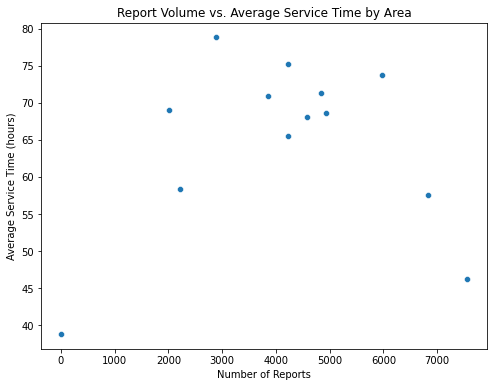

In [44]:
# Correlation between number of reports and average service time
report_volume = df.groupby('kreis_name')['service_name'].count()
service_time = df.groupby('kreis_name')['service_time'].mean()
print(report_volume.corr(service_time))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=report_volume, y=service_time)
plt.title('Report Volume vs. Average Service Time by Area')
plt.xlabel('Number of Reports')
plt.ylabel('Average Service Time (hours)')
plt.show()


In [52]:
kreis_data

day_of_week
Monday        43.183700
Tuesday       88.182127
Wednesday     58.518747
Thursday      74.716915
Friday       109.745954
Saturday      97.594270
Sunday        56.051020
Name: service_time, dtype: float64

C:\Users\simon\AppData\Local\Temp\ipykernel_7040\3320928451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['requested_datetime'].dt.day_name()


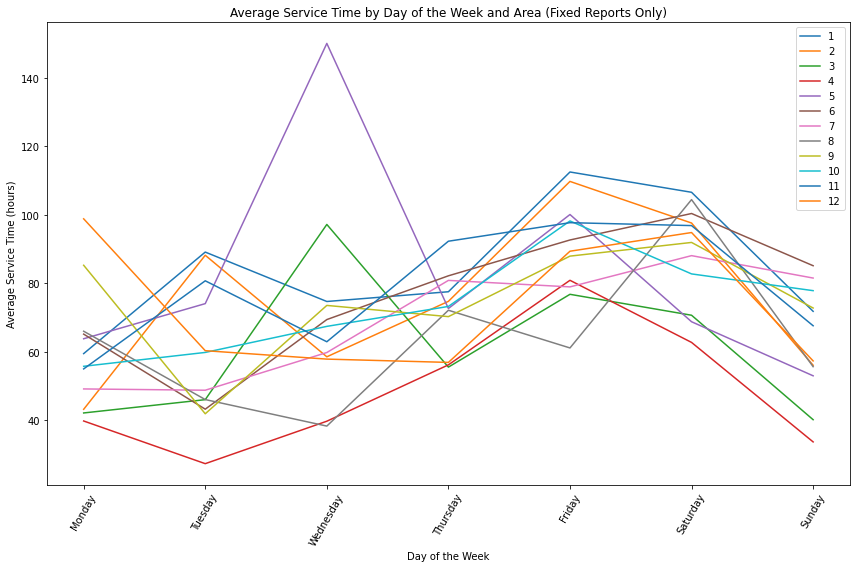

In [55]:
# Analyze service time by day of the week and area
df['day_of_week'] = df['requested_datetime'].dt.day_name()

plt.figure(figsize=(12, 8))
for kreis in np.sort(df['kreis_name'].unique()[:-1]):
    kreis_data = df[(df['status'] == 'fixed - council') & (df['kreis_name'] == kreis)].groupby('day_of_week')['service_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.plot(kreis_data.index, kreis_data.values, label=kreis)

plt.title('Average Service Time by Day of the Week and Area (Fixed Reports Only)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Service Time (hours)')
plt.xticks(rotation=60)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Making the dashboard

## Ideas 

Split into Kreise. What are the differences between Kreise? Response time, percentage of reports being x 

Look into response time

Forecast reports 2013-2022 and compare to actual reports 2022-2024. Perhaps forecast all categories individually and then combine

Look at graffiti (only crime column)

Make dashboard with map

Percentage fixed as a function of service code

Which service codes take the longest to fix?

There is a seasonality in requests. Predict requests for 2022-2023 and compare to actual requests.

Find most graffiti prone areas. Forecast maybe?

Make word clouds for each service type

10. Interactive Timeline of Major Events

    Create an interactive timeline that plots major events (e.g., spikes in certain problem types, resolution of high-profile issues, etc.).
    This can provide context around why certain trends or patterns may have occurred (e.g., weather events, public holidays, etc.).


Group reports by week or months in timeseries plot 

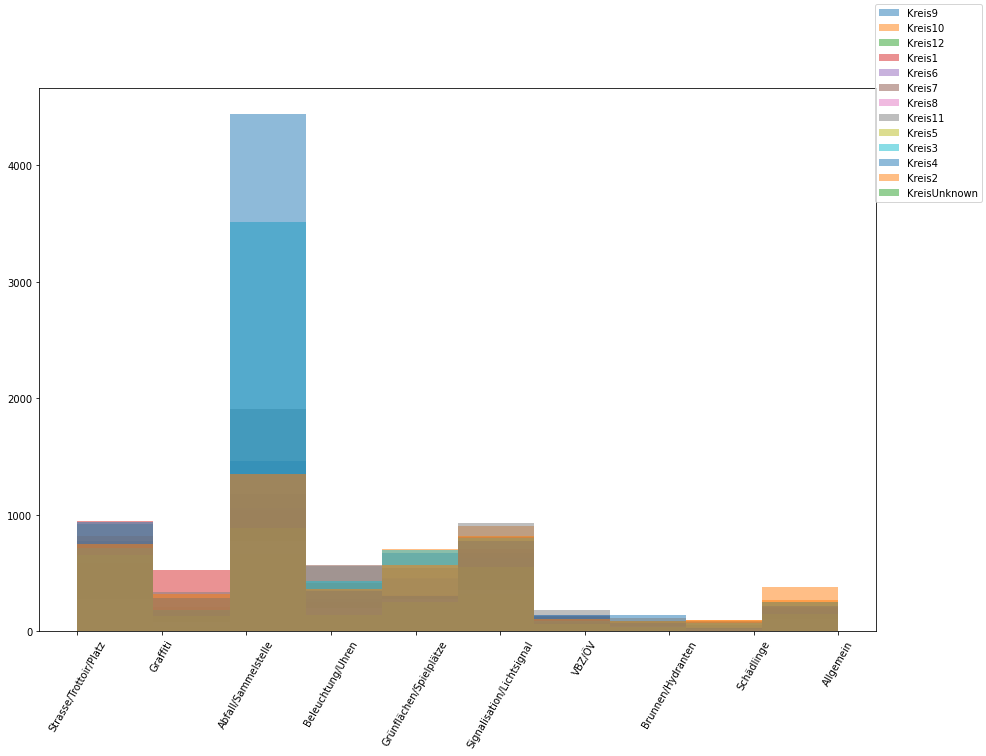

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
unique_y = df['kreis_name'].unique()

# Plot histograms for each unique value of y
for value in unique_y:
    ax.hist(df[df['kreis_name'] == value]['service_name'], alpha=0.5, label=f'Kreis{value}')
fig.legend()
plt.xticks(rotation=60);

In [19]:
df

,longitude,latitude,status,requested_datetime,updated_datetime,service_time,service_name,report_day,report_year,detail,media_url,service_notice,point,kreis_name
0,8.484226,47.374038,fixed - council,2013-03-14 15:16:15,2013-04-12 07:59:30,688.720833,Strasse/Trottoir/Platz,Thursday,2013,Auf dem Asphalt des Bürgersteigs hat es eine E...,No media,Diese Reparatur wird von uns in den kommenden ...,POINT (8.484226301305455 47.374037733747315),9
1,8.508193,47.395119,fixed - council,2013-03-14 15:17:57,2013-04-12 08:00:22,688.706944,Strasse/Trottoir/Platz,Thursday,2013,Vermessungspunkt ist nicht mehr bündig mit dem...,No media,Diese Reparatur wird von uns in den kommenden ...,POINT (8.508192919637715 47.39511862093258),10
2,8.559589,47.408259,fixed - council,2013-03-15 09:14:16,2013-04-12 08:08:10,670.898333,Strasse/Trottoir/Platz,Friday,2013,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Diese Reparatur wird von uns in den kommenden ...,POINT (8.559589406156757 47.40825905055263),12
3,8.521627,47.399131,fixed - council,2013-03-15 09:17:15,2013-04-12 08:09:05,670.863889,Strasse/Trottoir/Platz,Friday,2013,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Diese Reparatur wird von uns in den kommenden ...,POINT (8.521627371871496 47.39913121917527),10
4,8.538891,47.375455,fixed - council,2013-03-15 10:36:53,2013-04-23 13:50:33,939.227778,Abfall/Sammelstelle,Friday,2013,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Dieses Graffiti wird von uns in den kommenden ...,POINT (8.538890671691396 47.3754549474245),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54140,8.520284,47.403434,fixed - council,2024-09-04 16:29:01,2024-09-04 19:00:15,2.520556,Schädlinge,Wednesday,2024,Bei Waldspaziergang durch Tigermückenschwarm v...,https://www.zueriwieneu.ch/photo/60666.0.jpeg?...,Vielen Dank für Ihre Meldung. <br/> <br/> Weg...,POINT (8.520283960452161 47.40343443277984),10
54141,8.515094,47.379997,fixed - council,2024-09-04 16:43:28,2024-09-04 19:14:00,2.508889,Schädlinge,Wednesday,2024,Sehr geehrte Damen und Herren <br/> <br/> Sie...,https://www.zueriwieneu.ch/photo/60668.0.jpeg?...,Guten Abend <br/> <br/> Das glauben wir Ihnen...,POINT (8.515093730982437 47.379996803316224),4
54142,8.507043,47.352313,confirmed,2024-09-04 16:46:14,2024-09-04 17:22:04,0.597222,Grünflächen/Spielplätze,Wednesday,2024,"Flacher Wassertrog, ursprünglich zur Schuhrein...",No media,NaN,POINT (8.507043152473488 47.35231262125655),3
54143,8.524451,47.372560,fixed - council,2024-09-04 16:51:49,2024-09-04 16:53:07,0.021667,Abfall/Sammelstelle,Wednesday,2024,Diese KACK Velo versperrt seit Wochen den Velo...,https://www.zueriwieneu.ch/photo/60670.0.jpeg?...,Die Zweiradordnung wird Ihr Anliegen prüfen un...,POINT (8.524450819608292 47.372560228326954),4


# Predict reports

### Split data into train, val, test based on time.

Epoch 1/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.1460 - val_loss: 0.1291
Epoch 2/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.1321 - val_loss: 0.1298
Epoch 3/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.1298 - val_loss: 0.1296
Epoch 4/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.1302 - val_loss: 0.1284
Epoch 5/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.1303 - val_loss: 0.1285
Epoch 6/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.1300 - val_loss: 0.1280
Epoch 7/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.1301 - val_loss: 0.1290
Epoch 8/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.1291 - val_loss: 0.1282
Epoch 9/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.1300 - val_loss: 0.1281
Epoch 10/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.1308 - val_loss: 0.1281
Epoch 11/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.1299 - val_loss: 0.1278
Epoch 12/50
991/991 ━━━━━━━━━━

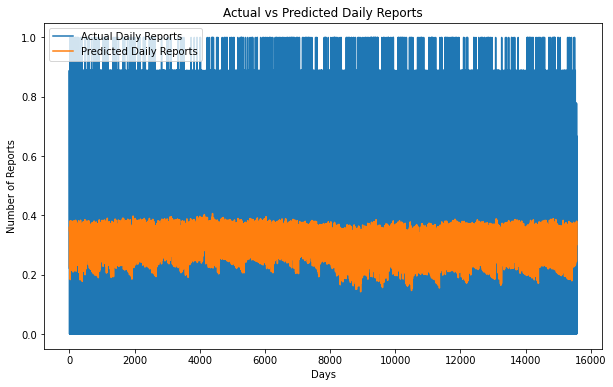

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Prepare the data
df1 = df[['requested_datetime', 'service_name']].copy()

# Extract time-based features
df1.loc[:,'day'] = df1['requested_datetime'].dt.day
df1.loc[:,'month'] = df1['requested_datetime'].dt.month
df1.loc[:,'year'] = df1['requested_datetime'].dt.year
df1.loc[:,'time_diff'] = df1['requested_datetime'].diff().dt.total_seconds().fillna(0)
df1.loc[:,'service_name'] = df1['service_name'].astype('category').cat.codes

train_split_end = '2022-01-01'
val_split_end = '2023-01-01'

# Train, validation, and test splits
train_data = df1[df1['requested_datetime'] < train_split_end]
val_data = df1[(df1['requested_datetime'] >= train_split_end) & (df1['requested_datetime'] < val_split_end)]
test_data = df1[df1['requested_datetime'] >= val_split_end]

# Drop 'requested_datetime' as it is not a feature for prediction
train_data = train_data.drop(columns=['requested_datetime'])
val_data   = val_data.drop(columns=['requested_datetime'])
test_data  = test_data.drop(columns=['requested_datetime'])

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled   = scaler.transform(val_data)
test_scaled  = scaler.transform(test_data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Use the first sequence_length as input
        y.append(data[i+sequence_length, 0]) # Predict the next day's number of reports (assuming it's the first column)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 32

# Create sequences
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val,   y_val   = create_sequences(val_scaled, sequence_length)
X_test,  y_test  = create_sequences(test_scaled, sequence_length)

# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Correct input shape for LSTM
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(1))  # Output shape is 1, since we're predicting a single value (number of reports)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=0,  # Adjust the number of epochs as needed
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Predict on test data
y_pred = model.predict(X_test)

# To plot the predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Daily Reports')
plt.plot(y_pred, label='Predicted Daily Reports')
plt.xlabel('Days')
plt.ylabel('Number of Reports')
plt.title('Actual vs Predicted Daily Reports')
plt.legend()
plt.show()


In [20]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

df1 = df[['requested_datetime', 'service_name']].copy()

# Extract time-based features
#df1.loc[:,'day_of_week'] = df1['requested_datetime'].dt.dayofweek
df1.loc[:,'day']   = df1['requested_datetime'].dt.day
df1.loc[:,'month'] = df1['requested_datetime'].dt.month
df1.loc[:,'year']  = df1['requested_datetime'].dt.year
df1.loc[:,'time_diff']    = df1['requested_datetime'].diff().dt.total_seconds().fillna(0)
df1.loc[:,'service_name'] = df1['service_name'].astype('category').cat.codes


train_split_end = '2022-01-01'
val_split_end = '2023-01-01'

# Train, validation, and test splits
train_data = df1[df1['requested_datetime'] < train_split_end]
val_data = df1[(df1['requested_datetime'] >= train_split_end) & (df1['requested_datetime'] < val_split_end)]
test_data = df1[df1['requested_datetime'] >= val_split_end]

# Drop 'requested_datetime' as it is not a feature for prediction
train_data = train_data.drop(columns=['requested_datetime'])
val_data   = val_data.drop(columns=['requested_datetime'])
test_data  = test_data.drop(columns=['requested_datetime'])

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled   = scaler.transform(val_data)
test_scaled  = scaler.transform(test_data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length,0])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 32

# Create sequences
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val,   y_val   = create_sequences(val_scaled, sequence_length)
X_test,  y_test  = create_sequences(test_scaled, sequence_length)


# Define the model
model = Sequential()
# Correct the input shape by specifying time steps and number of features
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # X_train.shape[1] is time steps, X_train.shape[2] is features
#model.add(Input(shape=((X_train.shape))))
model.add(LSTM(50, activation='relu'))
model.add(LSTM(25, activation='relu'))
model.add(Dense(y_train.shape[1]))  # Output shape is the same as the number of features in y
model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=5,  # Adjust the number of epochs as needed
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose = 1,
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Predict on test data
y_pred = model.predict(X_test)


ValueError: Input 0 of layer "lstm_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

In [170]:
X_train.shape

(31682, 32, 5)

In [159]:
import plotly.graph_objects as go

# Reverse the scaling for the true values and predicted values of the daily report count
y_test_daily_inv = scaler.inverse_transform(y_test)[:, 0]  # Take the first column
y_pred_daily_inv = scaler.inverse_transform(y_pred)[:, 0]  # Take the first column

# Extract dates for plotting
dates = pd.date_range(start=val_split_end, periods=len(y_test_daily_inv), freq='D')[sequence_length:]

# Create plotly figure
fig = go.Figure()

# Add trace for true daily report values
fig.add_trace(go.Scatter(
    x=dates,
    y=y_test_daily_inv,
    mode='lines',
    name='True Daily Reports'
))

# Add trace for predicted daily report values
fig.add_trace(go.Scatter(
    x=dates,
    y=y_pred_daily_inv,
    mode='lines',
    name='Predicted Daily Reports',
    line=dict(dash='dash')
))

fig.update_layout(
    title='True vs. Predicted Number of Daily Reports',
    xaxis_title='Date',
    yaxis_title='Number of Reports',
    legend_title='Legend'
)

fig.show()


In [143]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

# Define a function to create the LSTM dataset
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)


# Set time steps (number of previous time steps to use for prediction)
time_steps = 12  # Example: Using the previous 12 time steps to predict the next one

# Create the LSTM dataset for training
X_train, y_train = create_dataset(train_scaled, time_steps)

# Reshape input data to be 3D (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

X_test, y_test = create_dataset(test_scaled, time_steps)

# Reshape input data to be 3D (samples, time steps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go

# Assume 'df' is your DataFrame with columns 'requested_datetime' and 'service_name'
# Convert requested_datetime to date
df1 = df.copy()
df1['date'] = pd.to_datetime(df1['requested_datetime'].dt.date)

# Group by date and service_name to get the number of reports per service type per day
df_grouped = df1.groupby(['date', 'service_name']).size().reset_index(name='num_reports')

# Pivot the data to create columns for each service_name
df_pivot  = df_grouped.pivot(index='date', columns='service_name', values='num_reports').fillna(0).reset_index()

# Add the total number of reports per day as a separate column
df_pivot['total_reports'] = df_pivot.drop(columns='date').sum(axis=1)

# Split the data into training (until end of 2021), validation (2022), and testing (2023-2024)
train_data = df_pivot[df_pivot['date'] < '2022-01-01']
val_data   = df_pivot[(df_pivot['date'] >= '2022-01-01') & (df_pivot['date'] < '2023-01-01')]
test_data  = df_pivot[(df_pivot['date'] >= '2023-01-01') & (df_pivot['date'] <= '2024-01-01')]

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale each set independently to prevent data leakage
train_scaled = scaler.fit_transform(train_data.drop(columns='date'))
val_scaled = scaler.fit_transform(val_data.drop(columns='date'))
test_scaled = scaler.transform(test_data.drop(columns='date'))

# Function to create sequences for LSTM
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :])   # Use all columns except the last one for prediction
        y.append(data[i + sequence_length, -1])      # Predict the 'total_reports' column
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 32
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(val_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape input for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Early stopping callback with validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Use validation loss for early stopping
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

# Build LSTM model using Input layer
model = Sequential()
model.add(Input(shape=(sequence_length, X_train.shape[2])))  # Define input shape here
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(Dense(25))
model.add(Dense(1))

# Compile the model with a smaller learning rate
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation data
history = model.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_val, y_val),  # Specify validation data
    callbacks=[early_stopping]
)

# Predict using the test set
test_predictions = model.predict(X_test)

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_data['date'][sequence_length:], y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test_data['date'][sequence_length:], y=test_predictions.flatten(), mode='lines', name='Predicted'))
fig.update_layout(title='Predicted vs Actual Reports (2023-2024)', xaxis_title='Date', yaxis_title='Number of Reports')
fig.show()


KeyboardInterrupt: 

In [148]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go


# Assume 'df' is your DataFrame with columns 'requested_datetime' and 'service_name'
# Group by date to get the number of reports per day
df1 = df.copy()
df1['date'] = pd.to_datetime(df1['requested_datetime'].dt.date)  # Convert to date only
df_grouped = df1.groupby('date').size().reset_index(name='num_reports')

# Split the data into training (until 2022) and testing (2022-2024)
train_data = df_grouped[df_grouped['date'] < '2022-01-01']
test_data = df_grouped[(df_grouped['date'] >= '2022-01-01') & (df_grouped['date'] <= '2024-01-01')]

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale training data
train_scaled = scaler.fit_transform(train_data[['num_reports']])
test_scaled = scaler.transform(test_data[['num_reports']])

# Function to create sequences for LSTM
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 32
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test   = create_sequences(test_scaled, sequence_length)

# Reshape input for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test,  (X_test.shape[0], X_test.shape[1], 1))



early_stopping = EarlyStopping(
    monitor='loss',             # or 'val_accuracy', depending on your metric
    patience=5,                 # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,            # Minimum change to qualify as an improvement
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)


# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
if True:
    model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=[early_stopping])


C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - loss: 0.0037
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0022
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0023
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0022
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0021
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0022


In [151]:

# Predict using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
# Ensure 'predictions' column is initialized
train_data.loc[:,'predictions'] = np.nan
test_data.loc[:,'predictions'] = np.nan

# Assign train predictions (ensure alignment)
train_data.loc[train_data.index[sequence_length:], 'predictions'] = train_predictions.flatten()

# Assign test predictions (ensure alignment)
test_data.loc[test_data.index[sequence_length:], 'predictions'] = test_predictions.flatten()

# Combine the dataframes for visualization
combined_df = pd.concat([train_data, test_data])

# Visualization
fig = go.Figure()

# Add actual historical data
fig.add_trace(go.Scatter(
    x=train_data['date'],
    y=train_data['num_reports'],
    mode='lines',
    name='Historical Data (Train)',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_data['date'],
    y=test_data['num_reports'],
    mode='lines',
    name='Historical Data (Test)',
    line=dict(color='green')
))

# Add forecasted data
fig.add_trace(go.Scatter(
    x=combined_df['date'],
    y=combined_df['predictions'],
    mode='lines',
    name='Forecasted Data',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Forecast of Number of Reports Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Number of Reports'),
    font=dict(family='Roboto'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()


99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [150]:
# Filter data from 2022-2024 for actual and predicted values
test_data_2022_2024 = test_data[test_data['date'].between('2022-01-01', '2024-12-31')]

# Initialize a figure
fig = go.Figure()

# Plot the actual data from 2022-2024
fig.add_trace(go.Scatter(
    x=test_data_2022_2024['date'],
    y=test_data_2022_2024['num_reports'],
    mode='lines+markers',
    name='Actual Data (2022-2024)',
    line=dict(color='green')
))

# Plot the predicted data from 2022-2024
fig.add_trace(go.Scatter(
    x=test_data_2022_2024['date'],
    y=test_data_2022_2024['predictions'],
    mode='lines+markers',
    name='Predicted Data (2022-2024)',
    line=dict(color='red', dash='dash')  # Dashed line for predictions
))

# Update the layout
fig.update_layout(
    title='Actual vs Predicted Reports (2022-2024)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Number of Reports'),
    font=dict(family='Roboto'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()
